# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


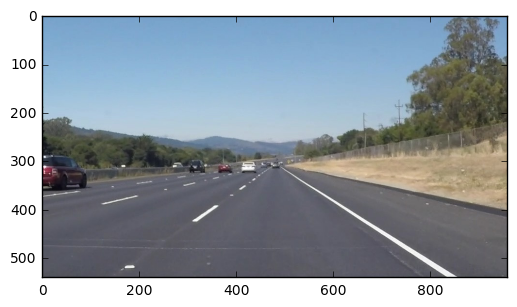

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [10]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

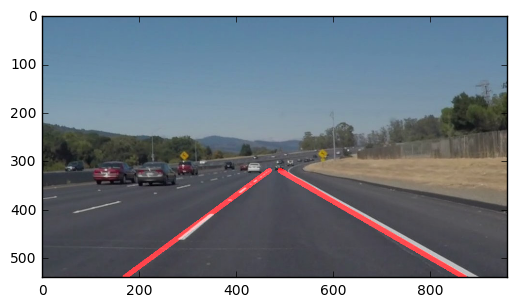

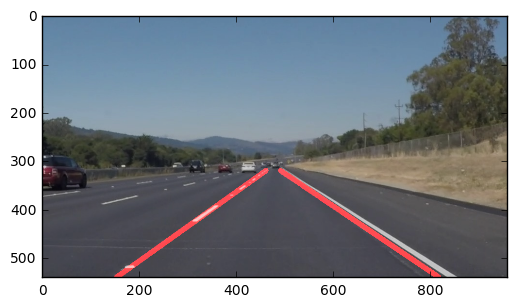

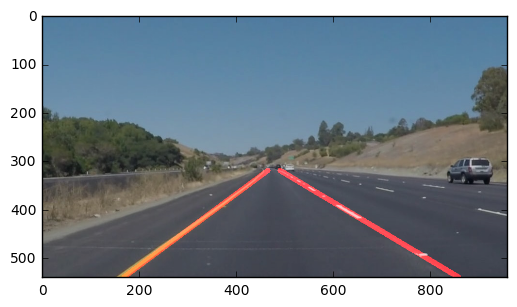

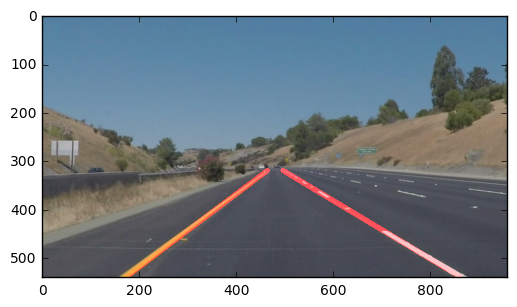

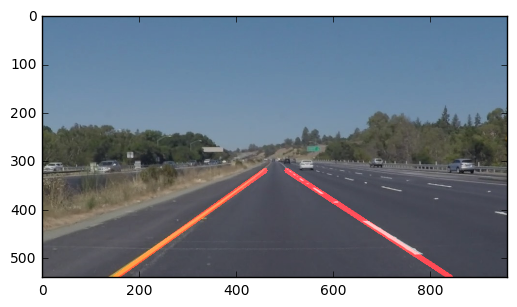

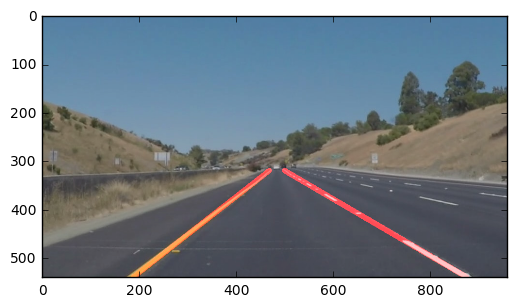

In [13]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os

%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1.4, tileGridSize=(8,8))
    return clahe.apply(gray)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    blur = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return blur

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def line_length(line):
    for x1, y1, x2, y2 in line:
        return np.sqrt(np.square(x2 - x1) + np.square(y2 - y1))

def find_longest_line(lines):
    longest_line = lines[0]
    for line in lines:
        length = line_length(line)
        if (length > line_length(longest_line)):
            longest_line = line
    return longest_line;

def get_line_slope(line):
    for x1, y1, x2, y2 in line:
        return (y2 - y1) / (x2 - x1)

def find_one_lane_line(img, vertices, top, rho, theta, threshold, min_line_len, max_line_gap):
    points = []
    min_slope = 0.4
    max_slope = 0.8
    roi = region_of_interest(img, vertices)
    lines = cv2.HoughLinesP(roi, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is None:
        return None
    for line in lines:
        for x1, y1, x2, y2 in line: 
            if max_slope >= get_line_slope(line) >= min_slope or -max_slope <= get_line_slope(line) <= -min_slope:
                points.append([x1, y1])
                points.append([x2, y2])

    vx, vy, cx, cy = cv2.fitLine(np.array(points), cv2.DIST_L2, 0, 0.01, 0.01)
    m = vy / vx
    b = cy - m * cx        
        
    x_top = int((top - b) / m)
    x_bottom = int((img.shape[0] - b) / m)
    return [[[x_bottom, img.shape[0], x_top, top]]]

def process_image(image):
    gray = grayscale(image)

    kernel_size = 5
    blur = gaussian_blur(gray, kernel_size)

    low = 50
    high = 150
    canny_img = canny(blur, low, high)

    rho = 2
    theta = np.pi / 180
    threshold = 15
    min_line_len = 20
    max_line_gap = 13
    x = image.shape[1]
    y = image.shape[0]
    top = 320
    delta = 20
    vertices_left = np.array([[(0, y), (x/2 - delta, top), (x/2, top), (x/2, y)]], dtype=np.int32)
    vertices_right = np.array([[(x/2, image.shape[0]), (x/2, top), (x/2 + delta, top), (x, y)]], dtype=np.int32)
    line_left = find_one_lane_line(canny_img, vertices_left, top, rho, theta, threshold, min_line_len, max_line_gap)
    line_right = find_one_lane_line(canny_img, vertices_right, top, rho, theta, threshold, min_line_len, max_line_gap)

    lines = np.append(line_left, line_right, axis=0)
    lines_img = np.zeros((*canny_img.shape, 3), dtype=np.uint8)
    draw_lines(lines_img, lines)

    final = weighted_img(lines_img, image)
    plt.figure()
    plt.imshow(final)

#reading in an image
images = os.listdir("test_images/")
for image_name in images:
    image = mpimg.imread('test_images/' + image_name)
    process_image(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [130]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1.4, tileGridSize=(8,8))
    return clahe.apply(gray)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    blur = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return blur

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_line_slope(line):
    for x1, y1, x2, y2 in line:
        return (y2 - y1) / (x2 - x1)

def find_one_lane_line(img, vertices, top, rho, theta, threshold, min_line_len, max_line_gap):
    points = []
    min_slope = 0.4
    max_slope = 0.8
    roi = region_of_interest(img, vertices)
    lines = cv2.HoughLinesP(roi, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is None:
        return None
    for line in lines:
        for x1, y1, x2, y2 in line: 
            if max_slope >= get_line_slope(line) >= min_slope or -max_slope <= get_line_slope(line) <= -min_slope:
                points.append([x1, y1])
                points.append([x2, y2])

    vx, vy, cx, cy = cv2.fitLine(np.array(points), cv2.DIST_L2, 0, 0.01, 0.01)
    m = vy / vx
    b = cy - m * cx        
        
    x_top = int((top - b) / m)
    x_bottom = int((img.shape[0] - b) / m)
    return [[[x_bottom, img.shape[0], x_top, top]]]
    
def process_image(image):
    gray = grayscale(image)

    kernel_size = 5
    blur = gaussian_blur(gray, kernel_size)

    low = 50
    high = 150
    canny_img = canny(blur, low, high)

    rho = 2
    theta = np.pi / 180
    threshold = 15
    min_line_len = 20
    max_line_gap = 13
    x = image.shape[1]
    y = image.shape[0]
    top = 320
    delta = 20
    vertices_left = np.array([[(0, y), (x/2 - delta, top), (x/2, top), (x/2, y)]], dtype=np.int32)
    vertices_right = np.array([[(x/2, image.shape[0]), (x/2, top), (x/2 + delta, top), (x, y)]], dtype=np.int32)
    line_left = find_one_lane_line(canny_img, vertices_left, top, rho, theta, threshold, min_line_len, max_line_gap)
    line_right = find_one_lane_line(canny_img, vertices_right, top, rho, theta, threshold, min_line_len, max_line_gap)

    lines = np.append(line_left, line_right, axis=0)
    lines_img = np.zeros((*canny_img.shape, 3), dtype=np.uint8)
    draw_lines(lines_img, lines)

    return weighted_img(lines_img, image)

Let's try the one with the solid white lane on the right first ...

In [45]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4



















  0%|          | 0/222 [00:00<?, ?it/s]
















  4%|▍         | 9/222 [00:00<00:02, 82.41it/s]
















  9%|▊         | 19/222 [00:00<00:02, 86.10it/s]
















 13%|█▎        | 29/222 [00:00<00:02, 89.79it/s]
















 18%|█▊        | 39/222 [00:00<00:01, 91.77it/s]
















 21%|██        | 47/222 [00:00<00:02, 82.86it/s]
















 25%|██▍       | 55/222 [00:00<00:02, 77.88it/s]
















 28%|██▊       | 63/222 [00:00<00:02, 74.89it/s]
















 32%|███▏      | 70/222 [00:00<00:02, 69.23it/s]
















 35%|███▍      | 77/222 [00:00<00:02, 67.39it/s]
















 38%|███▊      | 84/222 [00:01<00:02, 65.66it/s]
















 41%|████      | 91/222 [00:01<00:01, 65.62it/s]
















 44%|████▍     | 98/222 [00:01<00:01, 65.98it/s]
















 47%|████▋     | 105/222 [00:01<00:01, 65.08it/s]
















 50%|█████     | 112/222 [00:01<00:01, 64.07it/s]
















 54%|█████▎    |

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.94 s, sys: 1.09 s, total: 5.03 s
Wall time: 3.89 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [31]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4









  0%|          | 0/682 [00:00<?, ?it/s]






  1%|▏         | 9/682 [00:00<00:07, 88.12it/s]






  3%|▎         | 19/682 [00:00<00:07, 90.90it/s]






  4%|▍         | 29/682 [00:00<00:07, 92.79it/s]






  6%|▌         | 39/682 [00:00<00:06, 94.12it/s]






  7%|▋         | 47/682 [00:00<00:07, 86.12it/s]






  8%|▊         | 55/682 [00:00<00:07, 78.90it/s]






  9%|▉         | 63/682 [00:00<00:08, 73.44it/s]






 10%|█         | 70/682 [00:00<00:08, 70.09it/s]






 11%|█▏        | 77/682 [00:00<00:08, 67.63it/s]






 12%|█▏        | 84/682 [00:01<00:09, 65.54it/s]






 13%|█▎        | 91/682 [00:01<00:09, 64.63it/s]






 14%|█▍        | 98/682 [00:01<00:09, 62.72it/s]






 15%|█▌        | 105/682 [00:01<00:09, 60.79it/s]






 16%|█▋        | 112/682 [00:01<00:09, 58.47it/s]






 17%|█▋        | 118/682 [00:01<00:09, 56.49it/s]






 18%|█▊        | 124/682 [00:01<00:10, 53.96it/s]






 19%|█▉        | 130/682 [00:01<00:10, 53.19it/s]






 20%|█▉ 

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 13.3 s, sys: 2.93 s, total: 16.2 s
Wall time: 12.7 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Currently, my design is get the longest line from lines finded from Hough transform and use the slope of this longest line with one point of this longest line to generate left and right lane mark line in red.

It might not be the perfect algorithm, because the longest line might be wrong or is a noisy output. And I found a several corn case cause my solution failed for the optional challenge video which longest line might have slope == 0, this will cause wrong result.

I'm thinking use the mean slope of the left lines or right lines found by Hough transform but it might not very accurate either. Could you please give me some hints about the robusted algorithm?

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [35]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4











  0%|          | 0/251 [00:00<?, ?it/s]

error: /Users/jenkins/miniconda/1/x64/conda-bld/work/opencv-3.1.0/modules/imgproc/src/linefit.cpp:603: error: (-215) npoints2 >= 0 || npoints3 >= 0 in function fitLine


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))